In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = open('finitefault.txt')
lines = f.readlines()
lines[106] = lines[106].replace('Hypo','')
data = [[ float(s) for s in line.split()] for line in lines[27:]]

In [4]:
import pandas as pd
df = pd.DataFrame(data, columns = 'lat lon z rake slip ontime'.split())
df = df.rename(columns={'z':'depth'})
df['depth'] = 1000*df['depth']
df['strike'] = 15
df['dip'] = 18
df['L'] = 40000
df['W'] = 40000
df['reference'] = 'center'
df['slip'] /= 100
df['lon'] +=360
df.head()

,lat,lon,depth,rake,slip,ontime,strike,dip,L,W,reference
0,-39.001,287.862,81082.0,111.0,0.43,142.5,15,18,40000,40000,center
1,-38.652,287.977,81082.0,102.0,0.91,122.3,15,18,40000,40000,center
2,-38.304,288.092,81082.0,112.1,0.03,106.2,15,18,40000,40000,center
3,-37.956,288.206,81082.0,111.9,0.03,92.1,15,18,40000,40000,center
4,-37.608,288.321,81082.0,114.0,1.14,79.0,15,18,40000,40000,center


In [5]:
df = df['lat lon depth slip strike dip rake L W reference'.split()]

In [6]:
df.to_csv('earthquake.csv',index=False)

# Easywave format

In [7]:
df['reference']='C'
df['depth'] /=1000
df['L'] /=1000
df['W'] /=1000

In [8]:
f = open('fault.flt','w')

for index, row in df.iterrows():
    rowString = '-location {lon} {lat} {depth} -refpos {reference} -strike {strike} -dip {dip} -rake {rake} -slip {slip} -size {L} {W}\n'
    rowString = rowString.format(**row)
    f.write(rowString)

f.close()

In [9]:
!cat fault.flt

-location -72.138 -39.001 81.082 -refpos C -strike 15 -dip 18 -rake 111.0 -slip 0.43 -size 40.0 40.0
-location -72.023 -38.652 81.082 -refpos C -strike 15 -dip 18 -rake 102.0 -slip 0.91 -size 40.0 40.0
-location -71.908 -38.304 81.082 -refpos C -strike 15 -dip 18 -rake 112.1 -slip 0.03 -size 40.0 40.0
-location -71.794 -37.956 81.082 -refpos C -strike 15 -dip 18 -rake 111.9 -slip 0.03 -size 40.0 40.0
-location -71.679 -37.608 81.082 -refpos C -strike 15 -dip 18 -rake 114.0 -slip 1.14 -size 40.0 40.0
-location -71.564 -37.259 81.082 -refpos C -strike 15 -dip 18 -rake 105.5 -slip 1.13 -size 40.0 40.0
-location -71.45 -36.911 81.082 -refpos C -strike 15 -dip 18 -rake 106.7 -slip 0.23 -size 40.0 40.0
-location -71.335 -36.563 81.082 -refpos C -strike 15 -dip 18 -rake 108.7 -slip 0.14 -size 40.0 40.0
-location -71.22 -36.215 81.082 -refpos C -strike 15 -dip 18 -rake 105.4 -slip 0.03 -size 40.0 40.0
-location -71.106 -35.867 81.082 -refpos C -strike 15 -dip 18 -rake 100.0 -slip 1.13 -size 40

# Geoclaw format

In [10]:
from clawpack.geoclaw import dtopotools

In [11]:
dtopo_fname = 'dtopo_delouis.tt3'

In [12]:
fault = dtopotools.Fault()
fault.subfaults = []
df.loc[0,'lat']

for index, row in df.iterrows():
#     row = df.loc[0]
    usgs_subfault = dtopotools.SubFault()
    usgs_subfault.latitude = row['lat']
    usgs_subfault.longitude = row['lon']
    usgs_subfault.depth = row['depth']*1e3
    usgs_subfault.slip = row['slip']
    usgs_subfault.strike = row['strike']
    usgs_subfault.dip = row['dip']
    usgs_subfault.rake = row['rake']
    usgs_subfault.length = row['L']*1e3
    usgs_subfault.width = row['W']*1e3
    usgs_subfault.coordinate_specification = 'centroid'
    fault.subfaults.append(usgs_subfault)

In [13]:
fault.Mw()

8.7638829367089102

In [14]:
x = np.linspace(-75,-70,361)
y = np.linspace(-40,-30,361)
# x = np.linspace(-120,-60,361)
# y = np.linspace(-60,0,361)

times = [1.]
fault.create_dtopography(x,y,times)

In [15]:
fault.dtopo.write(dtopo_fname, dtopo_type=3)

Created  dtopo_delouis.png


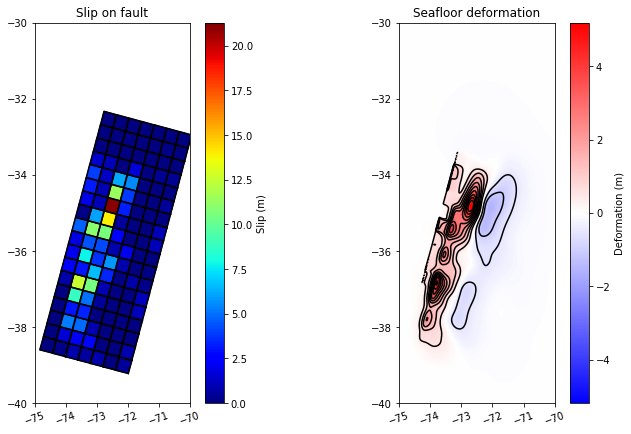

In [16]:
import os
plt.figure(figsize=(12,7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(-75,-70)
ax1.set_ylim(-40,-30)
ax2.set_xlim(-75,-70)
ax2.set_ylim(-40,-30)
fault.dtopo.plot_dZ_colors(1.,axes=ax2)
fname = os.path.splitext(os.path.split(dtopo_fname)[-1])[0] + '.png'
plt.savefig(fname)
print("Created ",fname)
